# Niger Conflict Analysis from ACLED Data

#### Overview of ACLED Data:
The Armed Conflict Location and Event Data (ACLED) is a disaggregated data, which reports information on conflict events in every country and territory in the world. It encompasses data on the type, agents, date, location and other attributes of demonstration events, political violence events, strategic developments, and other non-violence politically-relevant developments at specific points in time. The data is collected in real-time and published on a weekly basis.


#### Background of work:
Following the coup in Niamey on 07/26/2023, we would like to understand the trend of reported conflict events over time in Niger. For this analysis, ACLED data is downloaded for a 5-year period (2019-present), however the primary focus is on 2022-2023.

In [135]:
## Load libraries and data
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gmean
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import bokeh
from bokeh.io import show
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Legend, TabPanel, Tabs
from bokeh.layouts import column
import plotly.graph_objects as go
from IPython.display import display, clear_output
import ipywidgets as widgets
from plotly.subplots import make_subplots


from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


## Data
niger_adm1 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm1_IGNN_20230720.shp"
)

niger_adm2 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm2_IGNN_20230720.shp"
)

niger_adm3 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm3_IGNN_20230720.shp"
)


niger_df = pd.read_csv("../../data/Niger_conflict_data.csv")

In [136]:
color_palette = [
    "#4E79A7",  # Blue
    "#F28E2B",  # Orange
    "#E15759",  # Red
    "#76B7B2",  # Teal
    "#59A14F",  # Green
    "#EDC948",  # Yellow
    "#B07AA1",  # Purple
    "#FF9DA7",  # Pink
    "#9C755F",  # Brown
    "#BAB0AC",  # Gray
    "#7C7C7C",  # Dark gray
    "#6B4C9A",  # Violet
    "#D55E00",  # Orange-red
    "#CC61B0",  # Magenta
    "#0072B2",  # Bright blue
    "#329262",  # Peacock green
    "#9E5B5A",  # Brick red
    "#636363",  # Medium gray
    "#CD9C00",  # Gold
    "#5D69B1",  # Medium blue
]

In [137]:
def get_line_plot(
    ooklaUsers,
    title,
    source,
    subtitle=None,
    measure="conflictIndex",
    category="ADM2_FR",
):
    p2 = figure(
        x_axis_type="datetime", width=1000, height=400, toolbar_location="above"
    )
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(ooklaUsers[category].unique()):
        df = ooklaUsers[ooklaUsers[category] == adm2][
            ["event_date_map", measure]
        ].reset_index(drop=True)
        p2.line(
            df["event_date_map"],
            df[measure],
            line_width=2,
            line_color=color_palette[
                id % len(color_palette)
            ],  ## index doesn't exceed the palette size
            legend_label=adm2,
        )

    p2.legend.click_policy = "hide"
    if subtitle is not None:
        p2.title = subtitle

    title_fig = figure(
        title=title,
        toolbar_location=None,
        width=800,
        height=40,
    )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width = 0

    sub_title = figure(
        title=source,
        toolbar_location=None,
        width=800,
        height=40,
    )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style = "normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width = 0

    layout = column(title_fig, p2, sub_title)

    return layout

### 1). Average monthly conflict and fatalities over the years

The recorded data is from 01/01/2019 to 04/12/2024 and we clearly see that besides the peak in average monthly conflicts in 2022, the average monthly conflict occurence in Niger worsened after the coup in 2023, with 2024 already having the highest average fatalities/per month (137) and second-highest average conflicts/per month (67) in 4 months.

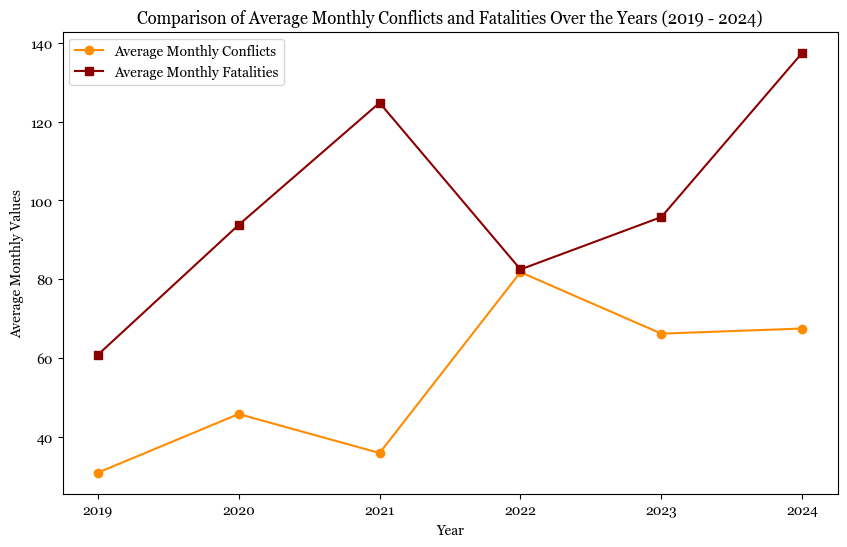

In [138]:
## Group by year
summ_years = (
    niger_df.groupby("year")
    .agg(
        {
            "event_id_cnty": "count",
            "fatalities": "sum",
            "location": pd.Series.nunique,
            "month": pd.Series.nunique,
        }
    )
    .rename(
        columns={
            "event_id_cnty": "total_conflicts",
            "fatalities": "total_fatalities",
            "location": "num_locations",
            "month": "num_months",
        }
    )
    .reset_index()
)

## Monthly averages for conflicts and fatalities
summ_years["avg_monthly_conflicts"] = (
    summ_years["total_conflicts"] / summ_years["num_months"]
).round(1)
summ_years["avg_monthly_fatalities"] = (
    summ_years["total_fatalities"] / summ_years["num_months"]
).round(1)


# PlottingPlot average monthly conflict and fatalities over the years
plt.figure(figsize=(10, 6))
plt.plot(
    summ_years["year"],
    summ_years["avg_monthly_conflicts"],
    marker="o",
    label="Average Monthly Conflicts",
    color="darkorange",
)
plt.plot(
    summ_years["year"],
    summ_years["avg_monthly_fatalities"],
    marker="s",
    label="Average Monthly Fatalities",
    color="darkred",
)
plt.title(
    "Comparison of Average Monthly Conflicts and Fatalities Over the Years (2019 - 2024)"
)
plt.xlabel("Year")
plt.ylabel("Average Monthly Values")
plt.legend()
plt.grid(False)
plt.show()

### 2). Top 10 Conflicts and Fatalities by location (2022-2024)

In 2022 and 2023, the number of fatalities was at least twice the number of conflict events in the top 10 locations where they occurred. Notably, in the first four months of 2024, fatalities were at least four times the number of conflict events.

Additionally, Niamey recorded the most conflicts in 2023 and continued to have the second-highest number of conflict events from January 1 to April 12, 2024. However, despite these high conflict figures, Niamey did not rank among the top 10 locations with the highest fatalities in any of the three years.

In [139]:
## Filter data for 2022, 2023, and 2024
df_filter = niger_df[niger_df["year"].isin([2022, 2023, 2024])]

## Group data by year and location
agg_df = (
    df_filter.groupby(["year", "location"])
    .agg({"event_id_cnty": "count", "fatalities": "sum"})
    .reset_index()
    .rename(
        columns={"event_id_cnty": "total_conflicts", "fatalities": "total_fatalities"}
    )
)

## Top 10 locations for conflicts and fatalities for each year
conflicts10 = (
    agg_df.sort_values(by=["year", "total_conflicts"], ascending=[True, False])
    .groupby("year")
    .head(10)
)
fatalities10 = (
    agg_df.sort_values(by=["year", "total_fatalities"], ascending=[True, False])
    .groupby("year")
    .head(10)
)

In [140]:
## Create figure
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("Top 10 Locations by Conflicts", "Top 10 Locations by Fatalities"),
)

## Years
years = [2022, 2023, 2024]

## Add traces for each year for conflicts and fatalities
for year in years:
    # first subplot = conflicts
    fig.add_trace(
        go.Bar(
            x=conflicts10[conflicts10["year"] == year]["location"],
            y=conflicts10[conflicts10["year"] == year]["total_conflicts"],
            name=f"Conflicts {year}",
            marker_color="darkorange",
            visible=(year == 2022),
        ),
        row=1,
        col=1,
    )
    # second subplot = fatalities
    fig.add_trace(
        go.Bar(
            x=fatalities10[fatalities10["year"] == year]["location"],
            y=fatalities10[fatalities10["year"] == year]["total_fatalities"],
            name=f"Fatalities {year}",
            marker_color="darkred",
            visible=(year == 2022),
        ),
        row=1,
        col=2,
    )

## Update initial figure layout to hide legend
fig.update_layout(title_text="Data for 2022", showlegend=False)


slider = widgets.SelectionSlider(
    options=[(str(year), year) for year in years],
    value=2022,
    description="Year",
    continuous_update=False,
    layout=widgets.Layout(width="20%", margin="auto"),
)


## Function to update the visibility of the traces based on the slider
def update_figures(change):
    selected_year = change["new"]
    clear_output(wait=True)

    ## Update visibility based on the selected year index
    year_index = years.index(selected_year)
    for i, trace in enumerate(fig.data):
        trace.visible = (i // 2) == year_index

    ## Update figure layout
    fig.update_layout(title_text=f"Data for {selected_year}", showlegend=False)

    ## Display slider and updated figure
    display(slider)
    display(fig)


## Slider
slider.observe(update_figures, names="value")

## Display
display(slider)
display(fig)

SelectionSlider(continuous_update=False, description='Year', layout=Layout(margin='auto', width='20%'), option…

### 3). Conflict Occurence by top 5 Event types (2022 - 2024)

Before the coup, "strategic development" conflict events and "violence against civilians" consistently dominated other event types such as "battles," "explosions/remote violence," and "protests." Notably, after the coup, specifically in November, there was a clear spike—an all-time high for the years under consideration—in the total number of conflicts attributed to "strategic developments." 

This spike was likely triggered by the French president's announcement on September 24, 2023, regarding the withdrawal of troops and diplomatic staff, including Ambassador Sylvain Itte. He highlighted that the full withdrawal of the 1,500 French troops stationed in the country was expected by the end of the year.

On the other hand, immediately following this spike in strategic development conflict events, there was a notable spike—another all-time high for the years under consideration—in the number of fatalities caused by "explosions/remote violence." In the following month, fatalities caused by "battles" surpassed those of other events. It is important to note that "battles" have generally been the leading cause of fatalities in the years under consideration, with the exception of the period around the coup, when "violence against civilians" was responsible for the highest fatalities and conflicts.

##### (a). All Conflicts

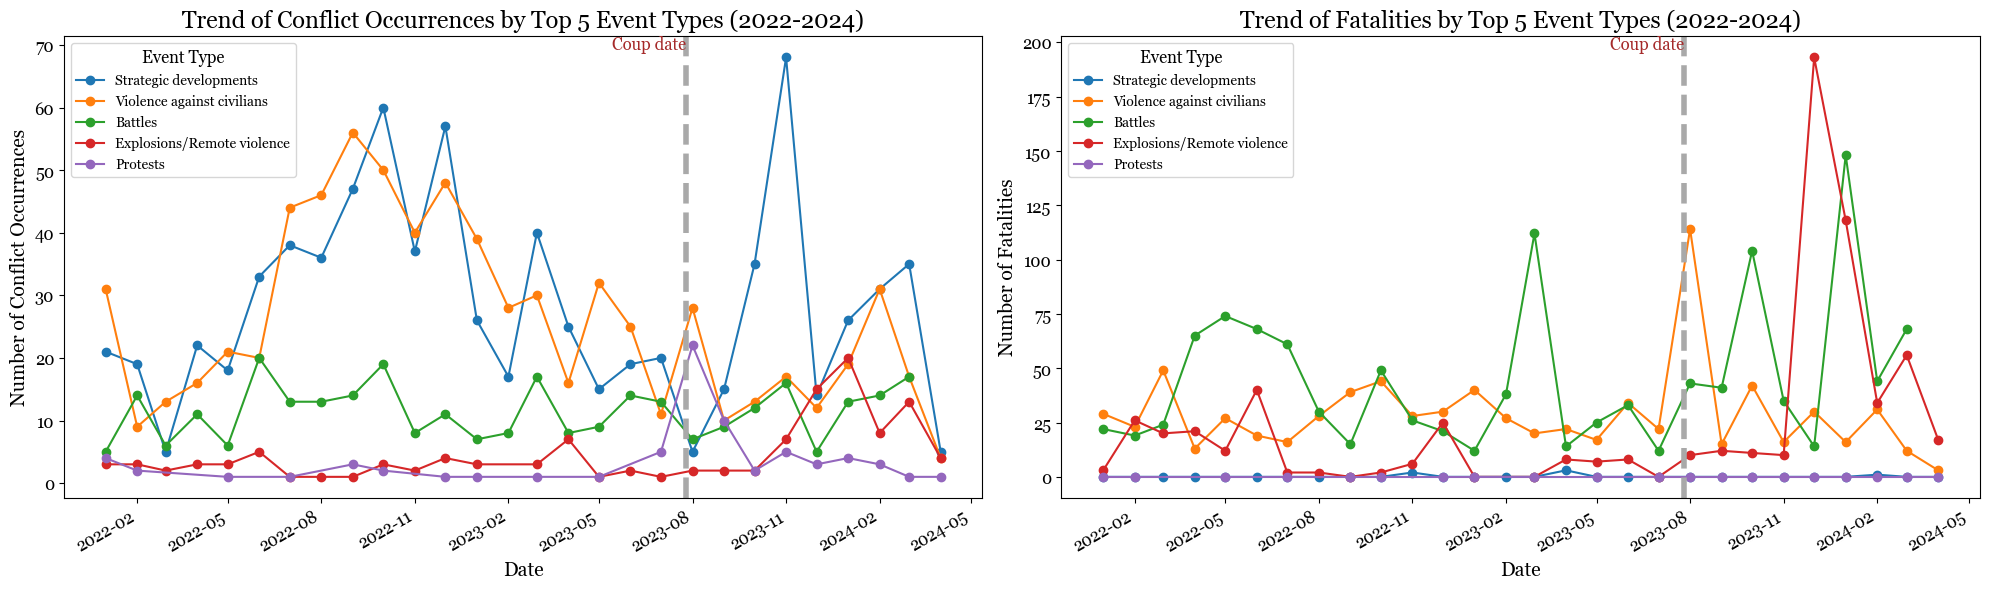

In [155]:
## All Conflicts
niger_df["event_date"] = pd.to_datetime(niger_df["event_date"], format="%d-%m-%Y")
niger_df["month_year"] = niger_df["event_date"].dt.to_period("M")

# Filter data for the years 2022, 2023, and 2024 and for only civilian-targetted
filtered_df1 = niger_df[(niger_df["year"].isin([2022, 2023, 2024]))]


# Group by event_type and month_year, then count occurrences and sum fatalities
grouped = (
    filtered_df1.groupby(["event_type", "month_year"])
    .agg({"event_id_cnty": "count", "fatalities": "sum"})
    .reset_index()
)

# Find the top 5 event types by total occurrences over the period
top_event_types = grouped.groupby("event_type")["event_id_cnty"].sum().nlargest(5).index

# Filter the grouped DataFrame to include only these top event types
top_events_grouped = grouped[grouped["event_type"].isin(top_event_types)]


# Define color palette
color_palette1 = {
    "Strategic developments": "#1f77b4",  # blue
    "Violence against civilians": "#ff7f0e",  # orange
    "Battles": "#2ca02c",  # green
    "Explosions/Remote violence": "#d62728",  # red
    "Protests": "#9467bd",  # purple
}

# Filter the top event types data
top_event_types = (
    grouped.groupby("event_type")["event_id_cnty"].sum().nlargest(5).index.tolist()
)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# First plot for conflict occurrences
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped["event_type"] == event_type]
    axs[0].plot(
        event_data["month_year"].dt.to_timestamp(),
        event_data["event_id_cnty"],
        marker="o",
        label=event_type,
        color=color_palette1[event_type],
    )

# Second plot for fatalities
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped["event_type"] == event_type]
    axs[1].plot(
        event_data["month_year"].dt.to_timestamp(),
        event_data["fatalities"],
        marker="o",
        label=event_type,
        color=color_palette1[event_type],
    )

# Highlight the specific date for the coup in both plots
coup_date = pd.Timestamp("2023-07-26")
for ax in axs:
    ax.axvline(x=coup_date, color="darkgrey", linestyle="--", lw=4)
    ax.text(
        coup_date,
        ax.get_ylim()[1],
        "Coup date",
        horizontalalignment="right",
        verticalalignment="top",
        color="brown",
        fontsize=12,
    )

# Formatting the plots
for ax in axs:
    ax.xaxis.set_major_locator(
        mdates.MonthLocator(interval=3)
    )  # Set major ticks interval every 3 months
    ax.xaxis.set_major_formatter(
        mdates.DateFormatter("%Y-%m")
    )  # Set the display format for dates
    ax.set_xlabel("Date", fontsize=14)
    ax.legend(title="Event Type", title_fontsize=12)
    ax.tick_params(axis="both", which="major", labelsize=12)

fig.autofmt_xdate()

axs[0].set_ylabel("Number of Conflict Occurrences", fontsize=14)
axs[0].set_title(
    "Trend of Conflict Occurrences by Top 5 Event Types (2022-2024)", fontsize=17
)

axs[1].set_ylabel("Number of Fatalities", fontsize=14)
axs[1].set_title("Trend of Fatalities by Top 5 Event Types (2022-2024)", fontsize=17)

plt.tight_layout()
plt.show()

##### (b). Civilian-targeted conflicts

For civilian-targeted events, "Violence against civilians" was the dominant event type for both fatalities and conflicts. A spike in fatalities caused by "explosions/remote violence" was observed around February 2024.

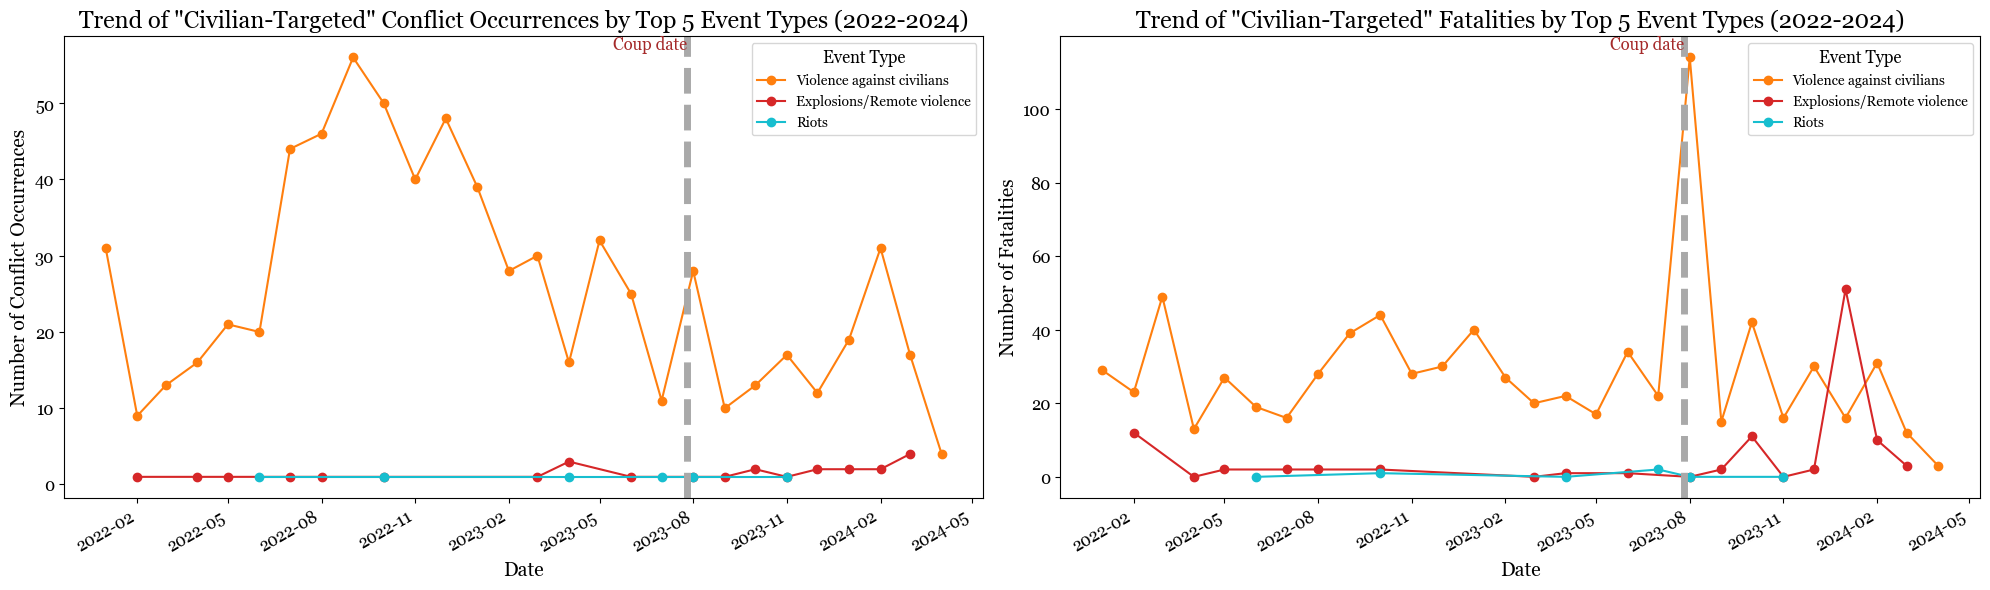

In [153]:
## Civilian Targetted Conflicts
# Filter data for the years 2022, 2023, and 2024 and for only civilian-targetted
filtered_df2 = niger_df[
    (niger_df["year"].isin([2022, 2023, 2024]))
    & (niger_df["civilian_targeting"] == "Civilian targeting")
]


# Group by event_type and month_year, then count occurrences and sum fatalities
grouped = (
    filtered_df2.groupby(["event_type", "month_year"])
    .agg({"event_id_cnty": "count", "fatalities": "sum"})
    .reset_index()
)

# Find the top 5 event types by total occurrences over the period
top_event_types = grouped.groupby("event_type")["event_id_cnty"].sum().nlargest(5).index

# Filter the grouped DataFrame to include only these top event types
top_events_grouped = grouped[grouped["event_type"].isin(top_event_types)]


color_palette2 = {
    "Violence against civilians": "#ff7f0e",  # orange
    "Explosions/Remote violence": "#d62728",  # red
    "Riots": "#17becf",  # cyan
}

# Filter the top event types data
top_event_types = (
    grouped.groupby("event_type")["event_id_cnty"].sum().nlargest(5).index.tolist()
)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a 1 by 2 subplot grid

# First plot for conflict occurrences
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped["event_type"] == event_type]
    axs[0].plot(
        event_data["month_year"].dt.to_timestamp(),
        event_data["event_id_cnty"],
        marker="o",
        label=event_type,
        color=color_palette2[event_type],
    )

# Second plot for fatalities
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped["event_type"] == event_type]
    axs[1].plot(
        event_data["month_year"].dt.to_timestamp(),
        event_data["fatalities"],
        marker="o",
        label=event_type,
        color=color_palette2[event_type],
    )

# Highlight the specific date for the coup in both plots
coup_date = pd.Timestamp("2023-07-26")
for ax in axs:
    ax.axvline(x=coup_date, color="darkgrey", linestyle="--", lw=5)
    ax.text(
        coup_date,
        ax.get_ylim()[1],
        "Coup date",
        horizontalalignment="right",
        verticalalignment="top",
        color="brown",
        fontsize=12,
    )

# Formatting the plots
for ax in axs:
    ax.xaxis.set_major_locator(
        mdates.MonthLocator(interval=3)
    )  # Set major ticks interval every 3 months
    ax.xaxis.set_major_formatter(
        mdates.DateFormatter("%Y-%m")
    )  # Set the display format for dates
    ax.set_xlabel("Date", fontsize=14)
    ax.legend(title="Event Type", fontsize=10, title_fontsize=12)
    ax.tick_params(axis="both", which="major", labelsize=12)

fig.autofmt_xdate()

axs[0].set_ylabel("Number of Conflict Occurrences", fontsize=14)
axs[0].set_title(
    'Trend of "Civilian-Targeted" Conflict Occurrences by Top 5 Event Types (2022-2024)',
    fontsize=17,
)

axs[1].set_ylabel("Number of Fatalities", fontsize=14)
axs[1].set_title(
    'Trend of "Civilian-Targeted" Fatalities by Top 5 Event Types (2022-2024)',
    fontsize=17,
)

plt.tight_layout()
plt.show()

### 4). Heatmap to show conflict and fatality occurences over past 2 years

In [ ]:
## Dictionary to map month numbers to month names
month_names = {
    "January": "Jan",
    "February": "Feb",
    "March": "Mar",
    "April": "Apr",
    "May": "May",
    "June": "Jun",
    "July": "Jul",
    "August": "Aug",
    "September": "Sep",
    "October": "Oct",
    "November": "Nov",
    "December": "Dec",
}

## Filter data for specified years
filtered_df = niger_df[niger_df["year"].isin([2022, 2023, 2024])]

## Aggregate data by year and month
pivot_df1 = (
    filtered_df.groupby(["year", "month"])
    .size()
    .unstack()
    .rename(columns=month_names)[list(month_names.values())]
)

pivot_df2 = (
    filtered_df.groupby(["year", "month"])["fatalities"]
    .sum()
    .unstack()
    .rename(columns=month_names)[list(month_names.values())]
)

## Color scales for heatmaps
colorscale_conflicts = [
    (0.0, "#F9D423"),  # Dark yellow
    (0.05, "#FF5722"),  # Dark orange
    (1.0, "#C62828"),  # Dark red
]

colorscale_fatalities = [
    (0.0, "#C6A300"),  # A darker shade of yellow
    (0.05, "#D84315"),  # A darker shade of orange
    (1.0, "#8E0000"),  # A darker shade of red
]


## Create the figures
fig_conflicts = go.Figure()
fig_fatalities = go.Figure()


years = sorted(set(pivot_df1.index).union(pivot_df2.index))

## Populate both figures with their respective traces, all initially invisible
for year in years:
    fig_conflicts.add_trace(
        go.Heatmap(
            z=pivot_df1.loc[year].values.reshape(1, -1),
            x=pivot_df1.columns,
            y=[f"{year} Conflicts"],
            colorscale=colorscale_conflicts,
            xgap=1,
            ygap=1,
            visible=False,  # Start all traces as invisible
        )
    )
    fig_fatalities.add_trace(
        go.Heatmap(
            z=pivot_df2.loc[year].values.reshape(1, -1),
            x=pivot_df2.columns,
            y=[f"{year} Fatalities"],
            colorscale=colorscale_fatalities,
            xgap=1,
            ygap=1,
            visible=False,
        )
    )

## Initialize the slider
slider = widgets.SelectionSlider(
    options=[(str(year), i) for i, year in enumerate(years)],
    value=0,
    description="Year",
    continuous_update=False,
    layout=widgets.Layout(width="20%", margin="auto"),
    style={"description_width": "initial", "handle_color": "lightblue"},
)


## Update layout and sliders for conflicts figure
fig_conflicts.update_layout(
    title={"text": "Yearly Data on Conflicts", "font": {"size": 19}},
    xaxis=dict(tickfont=dict(size=14)),
    yaxis=dict(tickfont=dict(size=14)),
    height=300,
    margin=dict(t=30),
)

## Update layout and sliders for fatalities figure
fig_fatalities.update_layout(
    title={"text": "Yearly Data on Fatalities", "font": {"size": 19}},
    xaxis=dict(tickfont=dict(size=14)),
    yaxis=dict(tickfont=dict(size=14)),
    height=300,
    margin=dict(t=30),
)


## Function to update the visibility of the traces based on the slider
def update_figures(change):
    year_idx = change["new"]

    clear_output(wait=True)

    # Update visibility based on the selected index
    for fig in [fig_conflicts, fig_fatalities]:
        for i, trace in enumerate(fig.data):
            trace.visible = i == year_idx

    # Display slider and updated figures
    display(slider)
    display(fig_conflicts)
    display(fig_fatalities)


# Observe slider for changes
slider.observe(update_figures, names="value")

# Display initial state
update_figures({"new": 0})

SelectionSlider(continuous_update=False, description='Year', index=2, layout=Layout(margin='auto', width='20%'…

### 5). Calculating Conflict Index

Conflict Index is calculated as a geometric mean of conflict events and fatalities at admin 2 level

In [160]:
acled = niger_df.copy()


def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [161]:
def get_acled_by_admin(
    niger_adm2,
    acled,
    columns=["ADM2_FR", "ADM2_PCODE", "ADM1_FR"],
    nearest=False,
    freq="m",
):
    niger_acled_adm2 = convert_to_gdf(acled)
    if nearest == True:
        niger_acled_adm2 = (
            niger_adm2.sjoin_nearest(niger_acled_adm2)[
                ["event_date", "fatalities", "event_type"] + columns
            ]
            .groupby(
                [pd.Grouper(key="event_date", freq=freq, closed="left")] + columns
            )["fatalities"]
            .agg(["sum", "count"])
            .reset_index()
        )
    else:
        niger_acled_adm2 = (
            niger_adm2.sjoin(niger_acled_adm2)[
                ["event_date", "fatalities", "event_type"] + columns
            ]
            .groupby(
                [pd.Grouper(key="event_date", freq=freq, closed="left")] + columns
            )["fatalities"]
            .agg(["sum", "count"])
            .reset_index()
        )

        ### Conflict
    niger_acled_adm2.rename(
        columns={"sum": "fatalities", "count": "event_id_cnty"}, inplace=True
    )
    niger_acled_adm2["conflictIndex"] = niger_acled_adm2.apply(
        lambda row: gmean([row["event_id_cnty"], row["fatalities"]]), axis=1
    )

    if freq == "m":
        niger_acled_adm2["event_date_map"] = niger_acled_adm2["event_date"].apply(
            lambda x: x.date().replace(day=1)
        )
    else:
        niger_acled_adm2["event_date_map"] = niger_acled_adm2["event_date"].apply(
            lambda x: x.date().replace(day=1)
        )
        niger_acled_adm2["event_date_map"] = niger_acled_adm2["event_date"].apply(
            lambda x: x.date().replace(month=1)
        )

    return niger_acled_adm2.reset_index()

In [162]:
niger_acled_adm1 = get_acled_by_admin(
    niger_adm1, acled, columns=["ADM1_FR", "ADM1_PCODE"]
)
niger_acled_adm2 = get_acled_by_admin(niger_adm2, acled)
niger_acled_adm0 = get_acled_by_admin(niger_adm1, acled, columns=["country"], freq="Y")

C:\Users\wb620404\AppData\Local\Temp\ipykernel_32660\2385084693.py:22: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\wb620404\AppData\Local\Temp\ipykernel_32660\2385084693.py:22: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\wb620404\AppData\Local\Temp\ipykernel_32660\2385084693.py:22: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



### 6). Geospatial changes in conflicts in Niger (2022 - 2023)

In [164]:
def get_size_category(item):
    if item < 5:
        return 1
    elif item < 15:
        return 5
    elif item < 30:
        return 10
    elif item < 50:
        return 20
    else:
        return 45

In [165]:
sizeCategoryLabels = {
    1: "Less than 5",
    5: "Less than 15",
    10: "Less than 30",
    20: "Less than 50",
    45: "More than 50",
}

In [166]:
def get_acled_conflicts_by_year(acled, start_date, end_date):
    acled_22 = acled[
        (acled["event_date"] >= start_date) & (acled["event_date"] <= end_date)
    ]
    acled_22 = (
        acled_22.groupby(
            ["latitude", "longitude", pd.Grouper(key="event_date", freq="Y")]
        )["fatalities"]
        .agg(["sum", "count"])
        .reset_index()
    )
    acled_22 = convert_to_gdf(acled_22)
    acled_22["sizeCategory"] = acled_22["sum"].apply(lambda x: get_size_category(x))
    acled_22.sort_values(by="count")

    return acled_22

In [167]:
acled_22 = get_acled_conflicts_by_year(acled, "2022-01-01", "2022-12-31")
acled_23 = get_acled_conflicts_by_year(acled, "2023-01-01", "2023-12-31")

C:\Users\wb620404\AppData\Local\Temp\ipykernel_32660\4082697207.py:7: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

C:\Users\wb620404\AppData\Local\Temp\ipykernel_32660\4082697207.py:7: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



In [168]:
niger_adm2["coords"] = niger_adm2["geometry"].apply(
    lambda x: x.representative_point().coords[:]
)
niger_adm2["coords"] = [coords[0] for coords in niger_adm2["coords"]]

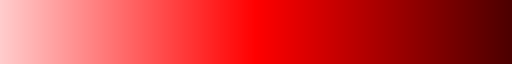

In [169]:
# colors = ["yellow", "darkred"]
# cmap_custom = LinearSegmentedColormap.from_list("custom_yellow_red", colors)

# colors = [(1, 0.8, 0.8), (1, 0, 0)]  # Light red to dark red
colors = [(1, 0.8, 0.8), (1, 0, 0), (0.3, 0, 0)]  # Red to darker red
cmap_custom = LinearSegmentedColormap.from_list("custom_reds", colors)
cmap_custom

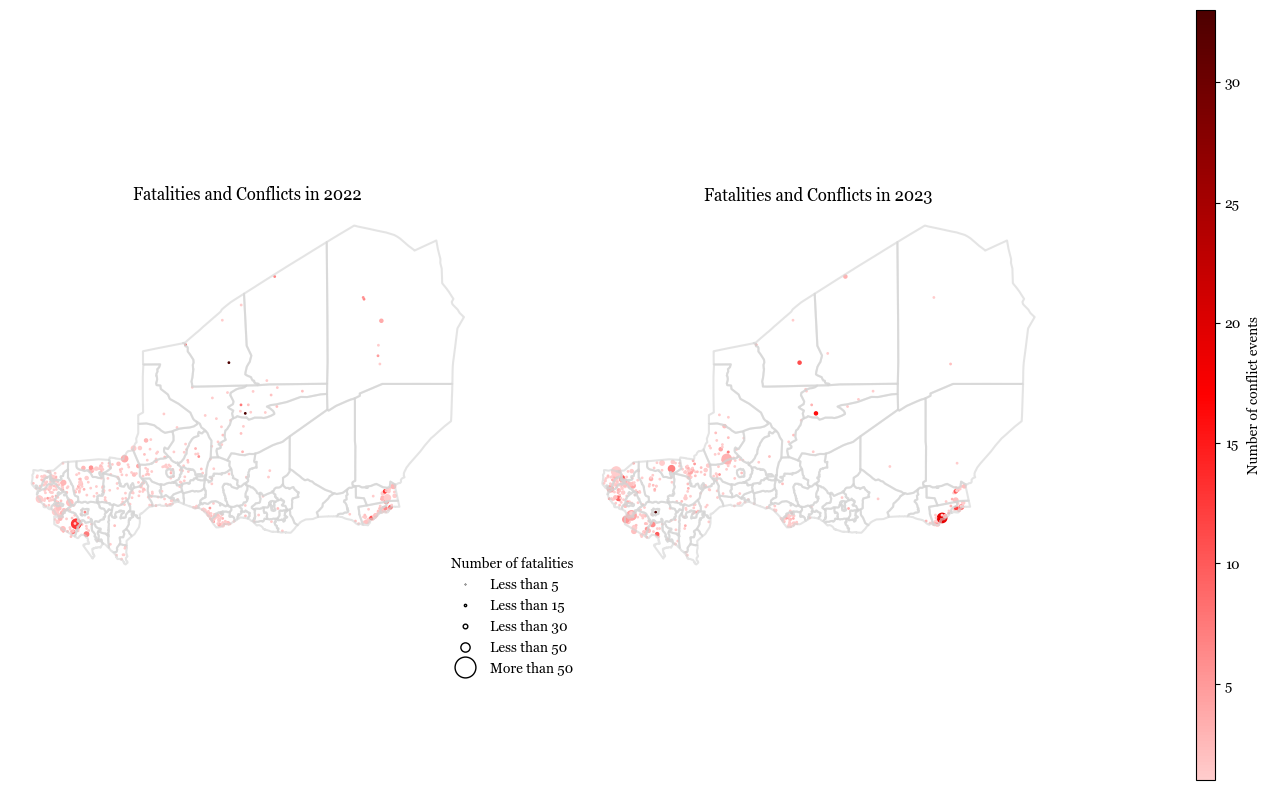

In [188]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(18, 10))

acled_22.plot(
    column="count", cmap=cmap_custom, ax=ax[0], markersize="sizeCategory", marker="o"
)
niger_adm2.boundary.plot(ax=ax[0], color="lightgrey", alpha=0.6, zorder=1)
ax[0].set_title("Fatalities and Conflicts in 2022")

acled_23.plot(column="count", cmap=cmap_custom, ax=ax[1], markersize="sizeCategory")
niger_adm2.boundary.plot(ax=ax[1], color="lightgrey", alpha=0.6, zorder=1)
ax[1].set_title("Fatalities and Conflicts in 2023")

# Create a colorbar and link it to the second axes
sm = plt.cm.ScalarMappable(cmap=cmap_custom)
sm.set_array(acled_23["count"])
cbar = plt.colorbar(sm, ax=ax, location="right", aspect=40, pad=0.1)
cbar.set_label("Number of conflict events")

for i in [0, 1]:
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

    ax[i].set_xticks([])
    ax[i].set_yticks([])

sizes = acled_23.sort_values(by="sizeCategory")["sizeCategory"].unique()
handles = []
for size in sizes:
    (handle,) = ax[0].plot(
        [],
        [],
        marker="o",
        markersize=size / 3,
        linestyle="",
        label=sizeCategoryLabels[size],
        markerfacecolor="white",
        markeredgecolor="black",
    )
    handles.append(handle)
ax[0].legend(
    handles=handles,
    title="Number of fatalities",
    loc="upper left",
    frameon=False,
    bbox_to_anchor=(0.9, 0.1),
)

plt.show()

### 7). Top 5 worst affected admin 1 regions in 2022

In [171]:
niger_acled_adm1[
    niger_acled_adm1["event_date"].between("2022-01-01", "2022-12-31")
].groupby([pd.Grouper(key="event_date", freq="Y"), "ADM1_FR"]).sum(
    ["fatalities", "event_id_cnty"]
).reset_index().sort_values(by="event_id_cnty", ascending=False)[
    ["event_date", "ADM1_FR", "fatalities", "event_id_cnty"]
].head(5)

C:\Users\wb620404\AppData\Local\Temp\ipykernel_32660\2563770677.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



,event_date,ADM1_FR,fatalities,event_id_cnty
6,2022-12-31,Tillabéri,592,357
1,2022-12-31,Diffa,251,159
0,2022-12-31,Agadez,33,156
3,2022-12-31,Maradi,41,139
5,2022-12-31,Tahoua,49,96


### 8). Top 5 worst affected admin 1 regions in 2023

In [172]:
niger_acled_adm1[
    niger_acled_adm1["event_date"].between("2023-01-01", "2023-12-31")
].groupby([pd.Grouper(key="event_date", freq="Y"), "ADM1_FR"]).sum(
    ["fatalities", "event_id_cnty"]
).reset_index().sort_values(by="event_id_cnty", ascending=False)[
    ["event_date", "ADM1_FR", "fatalities", "event_id_cnty"]
].head(5)

C:\Users\wb620404\AppData\Local\Temp\ipykernel_32660\1345114302.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



,event_date,ADM1_FR,fatalities,event_id_cnty
6,2023-12-31,Tillabéri,738,383
1,2023-12-31,Diffa,224,127
5,2023-12-31,Tahoua,95,76
3,2023-12-31,Maradi,31,70
0,2023-12-31,Agadez,30,54


In [173]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

## Rename "event_id_cnty" as "conflicts"
niger_acled_adm0.rename(columns={"event_id_cnty": "conflicts"}, inplace=True)


for type in ["conflicts", "fatalities"]:
    tabs.append(
        TabPanel(
            child=get_line_plot(
                niger_acled_adm0,
                f"{type.capitalize()} in the country",
                "Source: ACLED",
                subtitle="",
                category="country",
                measure=type,
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [123]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

tabs.append(
    TabPanel(
        child=get_line_plot(
            niger_acled_adm1,
            "Conflict Index by admin 1",
            "Source: ACLED",
            subtitle="",
            category="ADM1_FR",
        ),
    )
)

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [174]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []

for adm in list(niger_acled_adm2["ADM1_FR"].unique()):
    df = niger_acled_adm2[niger_acled_adm2["ADM1_FR"] == adm]

    tabs.append(
        TabPanel(
            child=get_line_plot(
                df,
                "Conflict Index by admin 2",
                "Source: ACLED",
                subtitle="",
            ),
            title=adm.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...